# Scaling-Up Raster Data Analysis

*March 12, 2024*

```sh
pip install dask numpy scipy
```

[**Download the dataset here and it make it accessible to this notebook.**](http://files.ntsg.umt.edu/data/GIS_Programming/data/MOD17A3HGF_C61_h19v08_annual_NPP_gCm-2yr-1_2001-2021.h5)

In [2]:
import h5py

hdf = h5py.File('data/MOD17A3HGF_C61_h19v08_annual_NPP_gCm-2yr-1_2001-2021.h5', 'r')

In [3]:
hdf.keys()

<KeysViewHDF5 ['NPP']>

In [4]:
hdf['NPP']

<HDF5 dataset "NPP": shape (21, 2400, 2400), type "<i2">

In [5]:
hdf['NPP'].attrs.keys()

<KeysViewHDF5 ['source', 'units']>

In [14]:
npp = hdf['NPP'][0].astype(np.float32) # First year of data (out of 21 years)
npp.shape                              # Verify this with shape

(2400, 2400)

In [8]:
npp.min()

-9999

In [12]:
npp == -9999

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [15]:
npp[npp == -9999] = np.nan # Convert -9999 values to NaN

## Introduction

- A good chip circa 2004: [https://en.wikipedia.org/wiki/Pentium_4](https://en.wikipedia.org/wiki/Pentium_4)
- A good chip circa 2024: [https://ark.intel.com/content/www/us/en/ark/products/236781/intel-core-i7-processor-14700-33m-cache-up-to-5-40-ghz.html](https://ark.intel.com/content/www/us/en/ark/products/236781/intel-core-i7-processor-14700-33m-cache-up-to-5-40-ghz.html)

## Bottlenecks in Computing

![](Moore.png)

*Image courtesy of XSEDE*

[Quantum tunneling is one of the reasons it's hard to make smaller and smaller transistors.](https://en.wikipedia.org/wiki/Quantum_tunnelling#Electronics)

---

## Motivation

Before we start working with huge raster datasets, let's explore some of the basic tools involved in parallel processing.

#### PARALLEL PROCESSING!!!!!!!!!!!!

In [17]:
my_numbers = np.arange(10, 50)
my_numbers

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49])

In [19]:
map(str, my_numbers)

In [22]:
list(map(str, my_numbers)) # Give me a list of these numbers converted to strings

['10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49']

In [16]:
def factorial(n):
    result = 1
    for i in range(n, 1, -1):
        result = result * i
    return result

In [26]:
%%timeit -n 100 #Magic function

factorial(5)

640 ns ± 65.5 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0, 0.5, 'Execution Time (secs)')

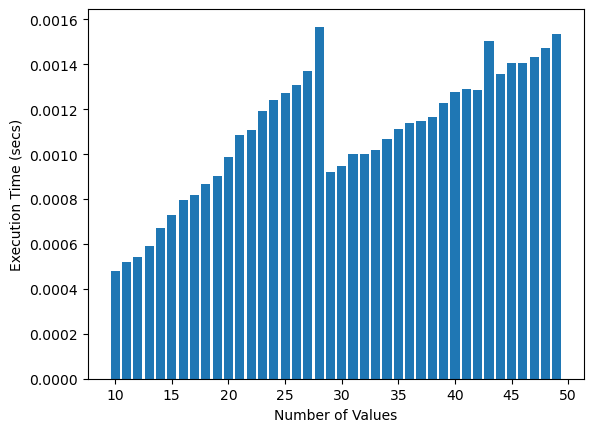

In [32]:
import dask
import numpy as np
import matplotlib.pyplot as plt
import timeit

times = []
for n in my_numbers:
    t = timeit.timeit(f"factorial({n})", globals = globals(), number = 1000)
    times.append(t)
    
plt.bar(my_numbers, times)
plt.xlabel('Number of Values')
plt.ylabel('Execution Time (secs)')

---

## Concurrent Processes

In [35]:
myfunc = lambda n: -1 ** n # -1 raised to the nth power

In [36]:
myfunc(5)

-1

In [39]:
# Create a list of 400,000,000 random integers (uint8 for data saving)
np.random.seed(42)
numbers = np.random.randint(low = 2, high = 200, size = int(4e8), dtype = np.uint8)
numbers.size

400000000

In [40]:
numbers = numbers.reshape((20000, 20000))

In [41]:
test = numbers.ravel()[100:200]
test

array([114,  88, 136,  26,   3, 149, 112,  90, 109,   7,  50, 143,  76,
       163,  89, 136,  60, 102, 164, 158,  75,  95, 104, 171, 183,  37,
        73,  13,  76, 189,  12,  74,  95,  16, 152,  61, 191,   2, 195,
       118, 191,  51,  25, 176,  76,   3, 191, 141,  80, 160,  52,  31,
        53, 109,   9,  99,  56, 166, 133,   6, 183,  65, 125, 170, 153,
       199, 127, 121, 132,  46,  13,  15,  39,  52,  17, 138, 157, 136,
       164,  42, 176,  22, 122, 169,  45,  74,  85, 117, 168,  58, 169,
        18,  19,  87, 103,   5, 133,  43,  90,  36], dtype=uint8)

In [44]:
%%timeit -n 1000 -r 10

# Below is the np equivalent of `map(myfunc, test)`
np.apply_along_axis(myfunc, 0, test)

# The result is how long it will take 1 CORE to do what we're asking it

16 µs ± 5.78 µs per loop (mean ± std. dev. of 10 runs, 1,000 loops each)


In [45]:
(30e-6/100) * numbers.size # This is how long it will theoretically take for 400,000,000 numbers

120.0

In [46]:
import dask.array as da

In [47]:
d_numbers = da.from_array(numbers)
d_numbers

dask.array<array, shape=(20000, 20000), dtype=uint8, chunksize=(11585, 11585), chunktype=numpy.ndarray>

#### Based on how many cores and how much memory you have, dask tells you the best way to break up your data for processing!

In [48]:
d_numbers = d_numbers.rechunk(balance = True) # This will break up `numbers` into chunks of equal size
d_numbers

dask.array<rechunk-merge, shape=(20000, 20000), dtype=uint8, chunksize=(10000, 10000), chunktype=numpy.ndarray>

In [49]:
%%timeit -n 1

np.apply_along_axis(myfunc, 0, numbers)

1.24 s ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### WOW! SUPER FAST! Especially compared to the estimated 2 minutes!

In [50]:
%%timeit -n 1

# map(myfunc, d_numbers)
result = d_numbers.map_blocks(myfunc)
result.compute() # This is where it actually runs

461 ms ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
1.24 / 461e-3 # We see through this computation that the chunking is 2.7 x faster

2.689804772234273

---

## Bottlenecks in Array Processing

In [53]:
21 * 2400 * 2400

120960000

In [54]:
npp.size * 21

120960000

In [55]:
num_bits = ((21 * 2400 * 2400) * 16)
num_bytes = num_bits / 8 # Convert to bytes (8 bits)
num_mb = num_bytes / 1e6 # Convert to megabytes (1,000,000 bytes)
num_mb

241.92

---

## Analyzing Large Raster Data Cubes

In [56]:
import h5py

hdf = h5py.File('data/MOD17A3HGF_C61_h19v08_annual_NPP_gCm-2yr-1_2001-2021.h5', 'r')
npp = hdf['NPP'][:]
hdf.close()

npp.shape

(21, 2400, 2400)

In [57]:
from scipy import stats

def linear_trend(array, n_years = 21):
    # linregress(x, y) takes two arguments: y is regressed on x
    result = stats.linregress(np.arange(0, n_years), array)
    return result[0] # Just the slope

In [62]:
 test1 = npp[:, 100, 100].shape # If we time the amount of time it will take for the whole dataset it's like 45 hours


### Estimating Time to Completion

---

## Concurrency in Python

![](concurrency.jpg)

*Image by Kelvin Wahome*

### Independent Processes

In [63]:
linear_trend

<function __main__.linear_trend(array, n_years=21)>

In [65]:
globals() # This tells us what's in the entire global namespace

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  "import h5py\n\nhdf = h5py.File('data/MOD17A3HGF_C61_h19v08_annual_NPP_gCm-2yr-1_2001-2021.h5', 'r')",
  "import h5py\n\nhdf = h5py.File('data/MOD17A3HGF_C61_h19v08_annual_NPP_gCm-2yr-1_2001-2021.h5', 'r')",
  'hdf.keys()',
  "hdf['NPP']",
  "hdf['NPP'].attrs.keys()",
  "npp = hdf['NPP'][0] # First year of data (out of 21 years)",
  "npp = hdf['NPP'][0] # First year of data (out of 21 years)\nnpp.shape           # Verify this with shape",
  'npp.min()',
  'import dask\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport timeit\n\ntimes = []\nfor n in my_numbers:\n    t = timeit.timeit(f"factorial({n})", globals = globals(), number = 1000)\n    times.append(t)\n    \npyplot.bar(my_numbers, times)\npyplot.

In [66]:
'linear_trend' in globals().keys()

True

### How Many Processes?

In [69]:
import os

# This way includes CPU tricks like "hyper-threading" to make a CPU core act like multiple cores
os.cpu_count()

24

In [70]:
import psutil 

# This tell you the actual physical CPUs on your computer
psutil.cpu_count(logical = False)

16

---

## Concurrent Raster Data Processing

**Now, let's see how to actually do concurrent raster processing with `dask`.**

When doing concurrent operations on arrays, we want to let `dask` do most of the work figuring out exactly how to chunk up the spatial domain.

In [ ]:
def maxval(x):
    return np.array([np.max(x[:,i]) for i in range(0, x[0].size)])

In [ ]:
d_npp = da.from_array(npp).reshape((21, 2400*2400)).rechunk((-1, 'auto'), block_size_limit = 65e6)
d_npp

In [ ]:
d_npp = da.from_array(npp).reshape((21, 2400*2400)).rechunk((-1, 1440000))
d_npp

In [ ]:
from matplotlib import pyplot

max_npp = max_npp.reshape((2400,2400)).astype(np.float32)
max_npp[max_npp < 0] = np.nan

plt.imshow(max_npp, interpolation = 'nearest')
plt.colorbar()
plt.show()

---

## At Home: Calculate a Linear Trend

Try running `map_blocks()` with a different function! The `linear_trend2()` function, below, is designed to calculate linear trends on each pixel in a block of pixels, so it can be used with `dask` and `map_blocks()` to calculate trends over large raster data cubes.

This took about 10 minutes with 4 processes on my Intel i7 CPU at home. You should expect it to take about the same amount of time.

In [ ]:
def linear_trend2(block, n_years = 21):
    x_data = np.arange(0, n_years)
    # A fancy way of saying call stats.linregress() in a for loop,
    #    once for each pixel in the block
    return np.array([
        stats.linregress(x_data, block[:,i])[0]
        for i in range(0, block[0].size)
    ])

In [56]:
%%timeit -n 1 -r 1

result = d_npp.map_blocks(linear_trend2, drop_axis = 0, dtype = np.int16)
result.compute()

10min 4s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
